In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Dataset Loading and Preprocessing

In [23]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
mnist = keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]

x_train = x_train.reshape([-1,x_train.shape[1], x_train.shape[2], 1])
x_test = x_test.reshape([-1,x_test.shape[1], x_test.shape[2], 1])

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Network Parameters
input_shape = x_train.shape[1:]
batch_size = 32
kernel_size = 3
latent_dim = 16

# Num of Encoder/Decoder per CNN layers
layer_filters = [32, 64]

In [24]:
save_dir = os.path.join(os.getcwd(), 'AutoEncoder')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

## Encoder Model

In [5]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras import backend as K

In [6]:
def encoder(inputs, layer_filters, latent_dim):
    x = inputs
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same'
                  )(x)
    shape = K.int_shape(x) 
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)
    
    encoder = keras.Model(inputs=inputs, outputs=latent, name='encoder')
    return encoder, shape

In [7]:
inputs = keras.Input(shape=input_shape, name='encoder_input')
encoder, shape = encoder(inputs, layer_filters, latent_dim)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-06-24 17:38:35.149893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-24 17:38:35.149948: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-06-24 17:38:35.149965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-06-24 17:38:35.150444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-24 17:38:35.150856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
shape

(None, 7, 7, 64)

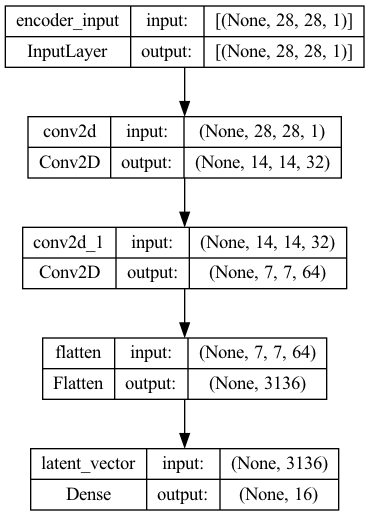

In [25]:
filepath1 = os.path.join(save_dir, 'encoder.png')

keras.utils.plot_model(encoder, to_file=filepath1, show_shapes=True)

## Decoder Model

In [10]:
def decoder(shape, layer_filters, latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim), name='decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) # Flatten
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same'
                           )(x)
    outputs = Conv2DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output'
                             )(x)

    decoder = keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
    return decoder

In [11]:
decoder = decoder(shape, layer_filters, latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

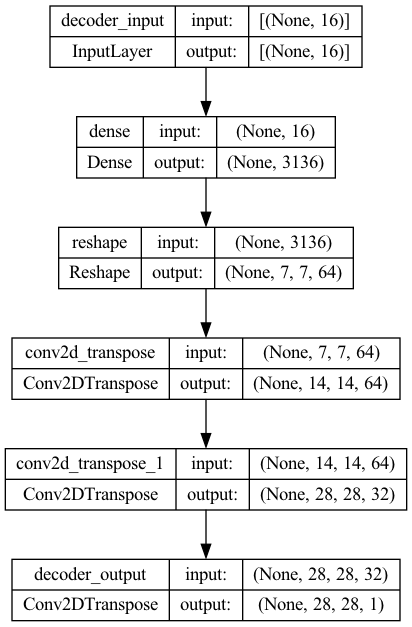

In [26]:
filepath2 = os.path.join(save_dir, 'decoder.png')

keras.utils.plot_model(decoder, to_file=filepath2, show_shapes=True)

## AutoEncoder = Encoder + Decoder

In [13]:
autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name='autoencoder')

In [14]:
autoencoder.compile(loss='mse',
                    optimizer='adam'
                   )
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


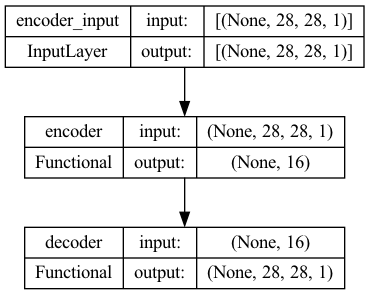

In [27]:
filepath3 = os.path.join(save_dir, 'autoencoder.png')

keras.utils.plot_model(autoencoder, to_file=filepath3, show_shapes=True)

In [16]:
autoencoder.fit(x_train, x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size
               )

2023-06-24 17:42:09.513511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1869/1875 [============================>.] - ETA: 0s - loss: 0.0212

2023-06-24 17:42:25.199148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 9ms/step - loss: 0.0212 - val_loss: 0.0106


In [17]:
x_decoded = autoencoder.predict(x_test)

 28/313 [=>............................] - ETA: 1s

2023-06-24 17:42:32.187141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 8ms/step


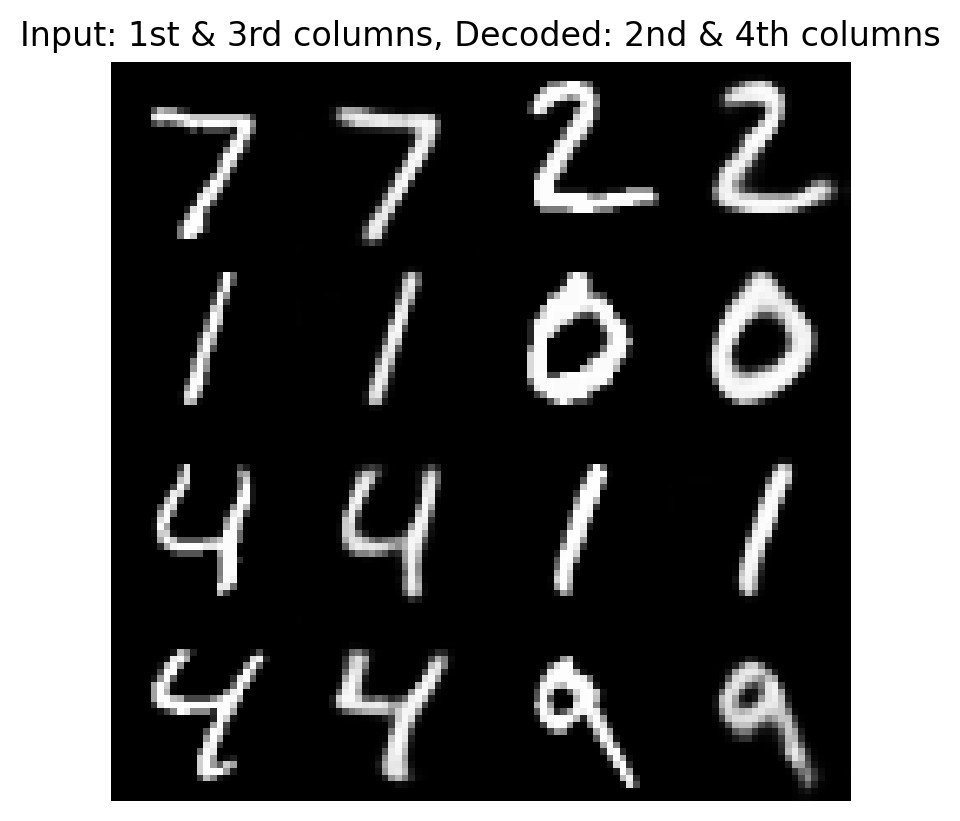

In [29]:
filepath4 = os.path.join(save_dir, 'input_and_decoded.png')

imgs = np.concatenate([x_test[:8], x_decoded[:8]], axis=1)
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Input: 1st & 3rd columns, Decoded: 2nd & 4th columns')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig(filepath4)
plt.show()